In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

AUROC의 t-test 비교

In [2]:
import mlflow
import pandas as pd
from sklearn.metrics import auc, roc_curve


from results.revision.revision_utils import  TRACKING_URI, RF_RUN_ID, BOOSTRAP_RUN_ID
from utils.serialization_ops import load_pickle
mlflow.set_tracking_uri(TRACKING_URI)

path = mlflow.artifacts.download_artifacts("mlflow-artifacts:/6/{run_id}/artifacts/fold_result.pickle".format(run_id=RF_RUN_ID))
fold_results_rf = load_pickle(path)

all_aurocs_rf = list()
n_folds = len(fold_results_rf["test_ids"])
for fold in range(n_folds):
    fold_bag_y_trues = fold_results_rf["fold_bag_y_trues"][fold]
    fold_bag_y_probs = fold_results_rf["fold_bag_y_probs"][fold]
    fpr, tpr, _ = roc_curve(fold_bag_y_trues, fold_bag_y_probs)
    all_aurocs_rf.append([fold, auc(fpr, tpr), "RF"])


path = mlflow.artifacts.download_artifacts("mlflow-artifacts:/6/{run_id}/artifacts/fold_result.pickle".format(run_id=BOOSTRAP_RUN_ID))
fold_results_mil = load_pickle(path)
n_folds = len(fold_results_mil["test_ids"])
all_aurocs_mil = list()
for fold in range(n_folds):
    fold_bag_y_trues = fold_results_mil["fold_bag_y_trues"][fold]
    fold_bag_y_probs = fold_results_mil["fold_bag_y_probs"][fold]
    fpr, tpr, _ = roc_curve(fold_bag_y_trues, fold_bag_y_probs)
    all_aurocs_mil.append([fold, auc(fpr, tpr), "MIL"])
    
auroc_df = pd.DataFrame(all_aurocs_rf + all_aurocs_mil, columns=["fold", "AUC", "Method"])

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SNV + CNV Top

In [3]:
import numpy as np
import pandas as pd
from core.metric import topk_recall
from results.revision.revision_utils import get_topk_folds

performnace_rf_snv_cnv = get_topk_folds(
    fold_results_rf["fold_instance_y_trues"],
    fold_results_rf["fold_instance_y_probs"]
)
performnace_mil_snv_cnv = get_topk_folds(
    fold_results_mil["fold_instance_y_trues"],
    fold_results_mil["fold_instance_y_probs"]
)


ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
performance_rf_snv_cnv = pd.DataFrame(performnace_rf_snv_cnv, columns=ks)
performance_rf_snv_cnv["Method"] = "RF"

performance_mil_snv_cnv = pd.DataFrame(performnace_mil_snv_cnv, columns=ks)
performance_mil_snv_cnv["Method"] = "MIL"


snv_cnv_topk = pd.concat([performance_rf_snv_cnv,performance_mil_snv_cnv])
snv_cnv_topk = snv_cnv_topk.melt(id_vars=["Method"], var_name="K", value_name="Value")
snv_cnv_topk.head()

,Method,K,Value
0,RF,1,0.779619
1,RF,1,0.794966
2,RF,1,0.782689
3,RF,1,0.820135
4,RF,1,0.812155


SNV Only

In [4]:
from utils.serialization_ops import load_pickle
from results.revision.revision_utils import DATA_PATH
from core.data_model import PatientDataSet

patient_dataset:PatientDataSet = load_pickle(DATA_PATH)

In [5]:
import numpy as np
from results.revision.revision_utils import get_snv_only_case

fold_results_rf_snv = {"fold_instance_y_trues":list(), "fold_instance_y_probs":list()}
fold_results_mil_snv = {"fold_instance_y_trues":list(), "fold_instance_y_probs":list()}
for fold_idx in range(n_folds):
    test_ids = fold_results_rf["test_ids"][fold_idx]
    snv_only_ids = get_snv_only_case(patient_dataset[test_ids])  
    
    test_indices = [test_ids.index(snv_id) for snv_id in snv_only_ids]
    instance_y_trues = [fold_results_rf["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
    instance_y_probs = [fold_results_rf["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
    fold_results_rf_snv["fold_instance_y_trues"].append(instance_y_trues)
    fold_results_rf_snv["fold_instance_y_probs"].append(instance_y_probs)

    instance_y_trues = [fold_results_mil["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
    instance_y_probs = [fold_results_mil["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
    fold_results_mil_snv["fold_instance_y_trues"].append(instance_y_trues)
    fold_results_mil_snv["fold_instance_y_probs"].append(instance_y_probs)
    
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]

n_folds = len(fold_results_rf["test_ids"])
performance = np.ones((n_folds, len(ks)))

performnace_rf_snv = get_topk_folds(
    fold_results_rf_snv["fold_instance_y_trues"],
    fold_results_rf_snv["fold_instance_y_probs"]
)
performnace_mil_snv = get_topk_folds(
    fold_results_mil_snv["fold_instance_y_trues"],
    fold_results_mil_snv["fold_instance_y_probs"]
)

ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
performance_rf_snv = pd.DataFrame(performnace_rf_snv, columns=ks)
performance_rf_snv["Method"] = "RF"

performance_mil_snv = pd.DataFrame(performnace_mil_snv, columns=ks)
performance_mil_snv["Method"] = "MIL"


snv_topk = pd.concat([performance_rf_snv,performance_mil_snv])
snv_topk = snv_topk.melt(id_vars=["Method"], var_name="K", value_name="Value")

CNV only

In [6]:
import numpy as np
from results.revision.revision_utils import get_cnv_only_case
from core.metric import Metric
import matplotlib.pyplot as plt

fold_results_rf_cnv = {"fold_instance_y_trues":list(), "fold_instance_y_probs":list()}
fold_results_mil_cnv = {"fold_instance_y_trues":list(), "fold_instance_y_probs":list()}
for fold_idx in range(n_folds):
    test_ids = fold_results_rf["test_ids"][fold_idx]
    cnv_only_ids = get_cnv_only_case(patient_dataset[test_ids])  
    
    test_indices = [test_ids.index(snv_id) for snv_id in cnv_only_ids]
    instance_y_trues = [fold_results_rf["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
    instance_y_probs = [fold_results_rf["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
    fold_results_rf_cnv["fold_instance_y_trues"].append(instance_y_trues)
    fold_results_rf_cnv["fold_instance_y_probs"].append(instance_y_probs)

    instance_y_trues = [fold_results_mil["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
    instance_y_probs = [fold_results_mil["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
    fold_results_mil_cnv["fold_instance_y_trues"].append(instance_y_trues)
    fold_results_mil_cnv["fold_instance_y_probs"].append(instance_y_probs)
    
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]

n_folds = len(fold_results_rf["test_ids"])
performance = np.ones((n_folds, len(ks)))

performnace_rf_cnv = get_topk_folds(
    fold_results_rf_cnv["fold_instance_y_trues"],
    fold_results_rf_cnv["fold_instance_y_probs"]
)
performnace_mil_cnv = get_topk_folds(
    fold_results_mil_cnv["fold_instance_y_trues"],
    fold_results_mil_cnv["fold_instance_y_probs"]
)

ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
performance_rf_cnv = pd.DataFrame(performnace_rf_cnv, columns=ks)
performance_rf_cnv["Method"] = "RF"

performance_mil_cnv = pd.DataFrame(performnace_mil_cnv, columns=ks)
performance_mil_cnv["Method"] = "MIL"


cnv_topk = pd.concat([performance_rf_cnv,performance_mil_cnv])
cnv_topk = cnv_topk.melt(id_vars=["Method"], var_name="K", value_name="Value")
cnv_topk.head()

,Method,K,Value
0,RF,1,0.625000
1,RF,1,0.549296
2,RF,1,0.537313
3,RF,1,0.612245
4,RF,1,0.633333


AUC - Cohen's d: -0.5027641953705015


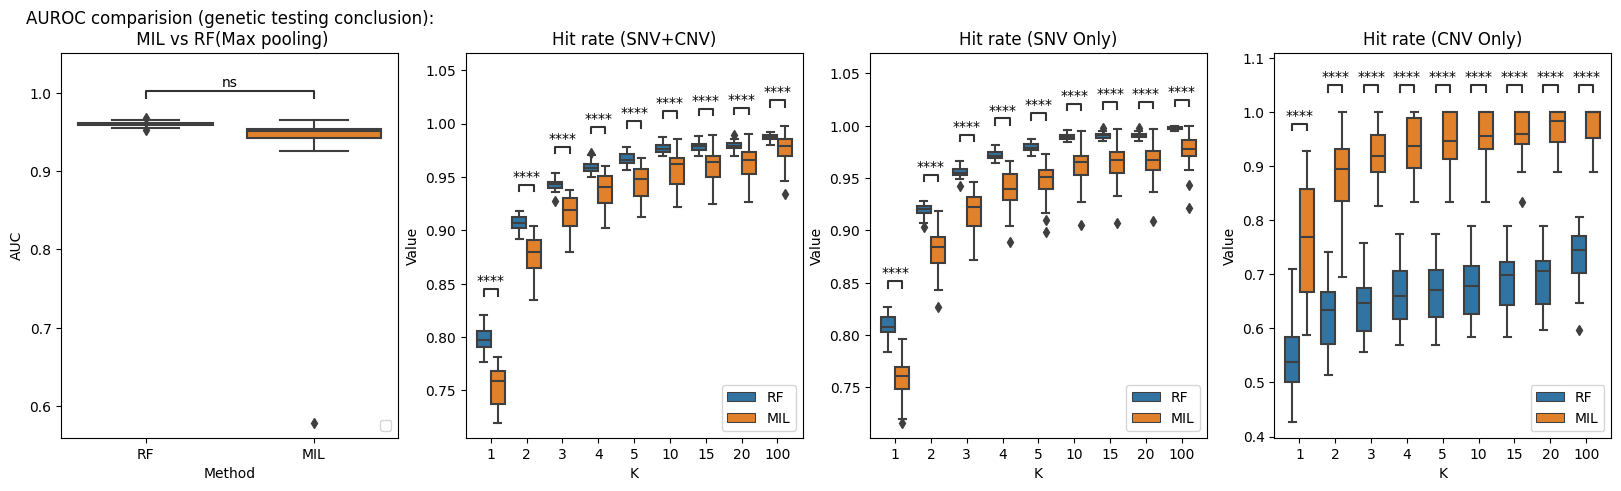

In [7]:

# Boxplot
import seaborn as sns 
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu


from results.revision.revision_utils import cohen_d


fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(
    data=auroc_df,
    x="Method",
    y="AUC",
    ax=axes[0]
)
pairs = [
    ("RF", "MIL")
]
t_stat, p_value = ttest_ind(
    auroc_df.loc[auroc_df["Method"]=="MIL"]["AUC"], 
    auroc_df.loc[auroc_df["Method"]=="RF"]["AUC"], 
    equal_var=False
)
d = cohen_d(auroc_df.loc[auroc_df["Method"]=="MIL"]["AUC"], auroc_df.loc[auroc_df["Method"]=="RF"]["AUC"])
print(f"AUC - Cohen's d: {d}")
add_stat_annotation(
    axes[0],
    data=auroc_df,
    x="Method",
    y="AUC",
    box_pairs=pairs,
    perform_stat_test=False,
    text_format='star',
    loc='inside',
    verbose=0,
    comparisons_correction=None,
    pvalues=[p_value],
)
axes[0].set_title("AUROC comparision (genetic testing conclusion):\n MIL vs RF(Max pooling)")

####### SNV+CNV
sns.boxplot(
    data=snv_cnv_topk,
    x="K",
    y="Value",
    hue="Method",
    ax=axes[1]
    
)
pairs = [
    ((k, "RF"), (k, "MIL"))
    for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]
]
p_valeus = [
    ttest_ind(
        snv_cnv_topk.loc[(snv_cnv_topk["K"]==k) & (snv_cnv_topk["Method"]=="RF")]["Value"],
        snv_cnv_topk.loc[(snv_cnv_topk["K"]==k) & (snv_cnv_topk["Method"]=="MIL")]["Value"],
    ).pvalue
    for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]
]
add_stat_annotation(
    axes[1],
    data=snv_cnv_topk,
    x="K",
    y="Value",
    hue="Method",
    box_pairs=pairs,
    perform_stat_test=False,
    text_format='star',
    loc='inside',
    verbose=0,
    comparisons_correction=None,
    pvalues=p_valeus,
)
axes[1].set_title("Hit rate (SNV+CNV)")

####### SNV
sns.boxplot(
    data=snv_topk,
    x="K",
    y="Value",
    hue="Method",
    ax=axes[2]
)
pairs = [
    ((k, "RF"), (k, "MIL"))
    for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]
]
p_valeus = [
    ttest_ind(
        snv_topk.loc[(snv_topk["K"]==k) & (snv_topk["Method"]=="RF")]["Value"],
        snv_topk.loc[(snv_topk["K"]==k) & (snv_topk["Method"]=="MIL")]["Value"],
    ).pvalue
    for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]
]
add_stat_annotation(
    axes[2],
    data=snv_topk,
    x="K",
    y="Value",
    hue="Method",
    box_pairs=pairs,
    perform_stat_test=False,
    text_format='star',
    loc='inside',
    verbose=0,
    comparisons_correction=None,
    pvalues=p_valeus,
)
axes[2].set_title("Hit rate (SNV Only)")

####### CNV
sns.boxplot(
    data=cnv_topk,
    x="K",
    y="Value",
    hue="Method",
    ax=axes[3]
)
pairs = [
    ((k, "RF"), (k, "MIL"))
    for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]
]
p_valeus = [
    ttest_ind(
        cnv_topk.loc[(cnv_topk["K"]==k) & (cnv_topk["Method"]=="RF")]["Value"],
        cnv_topk.loc[(cnv_topk["K"]==k) & (cnv_topk["Method"]=="MIL")]["Value"],
    ).pvalue
    for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]
]
add_stat_annotation(
    axes[3],
    data=cnv_topk,
    x="K",
    y="Value",
    hue="Method",
    box_pairs=pairs,
    perform_stat_test=False,
    text_format='star',
    loc='inside',
    verbose=0,
    comparisons_correction=None,
    pvalues=p_valeus,
)
axes[3].set_title("Hit rate (CNV Only)")

for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="lower right")
    
plt.savefig("results/1_3_RF_vs_MIL.png")